# Running Stable Diffusion 3 with LoRA finetuning

## Install Dependencies

In [1]:
!pip install -q -U git+https://github.com/huggingface/diffusers
!pip install -q -U \
    transformers \
    accelerate \
    sentencepiece \
    wandb \
    bitsandbytes \
    pandas \
    pyarrow \
    peft \
    ipywidgets

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yt-dlp 2024.10.22 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.


*FILLING IN THE FORM WILL NOT BE NECESSARY ONCE WE MAKE THIS A REQUIRED RESOURCE**

SD3 is gated so we need to go to [Stable Diffusion 3 Medium Hugging Face page](https://huggingface.co/stabilityai/stable-diffusion-3-medium-diffusers), fill in the form and accept the gate. Once you are in, you need to log in so that your system knows you’ve accepted the gate. Use the command below to log in:

In [2]:
from huggingface_hub import login

login()

## Let's see what SD3 can do out of the box


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

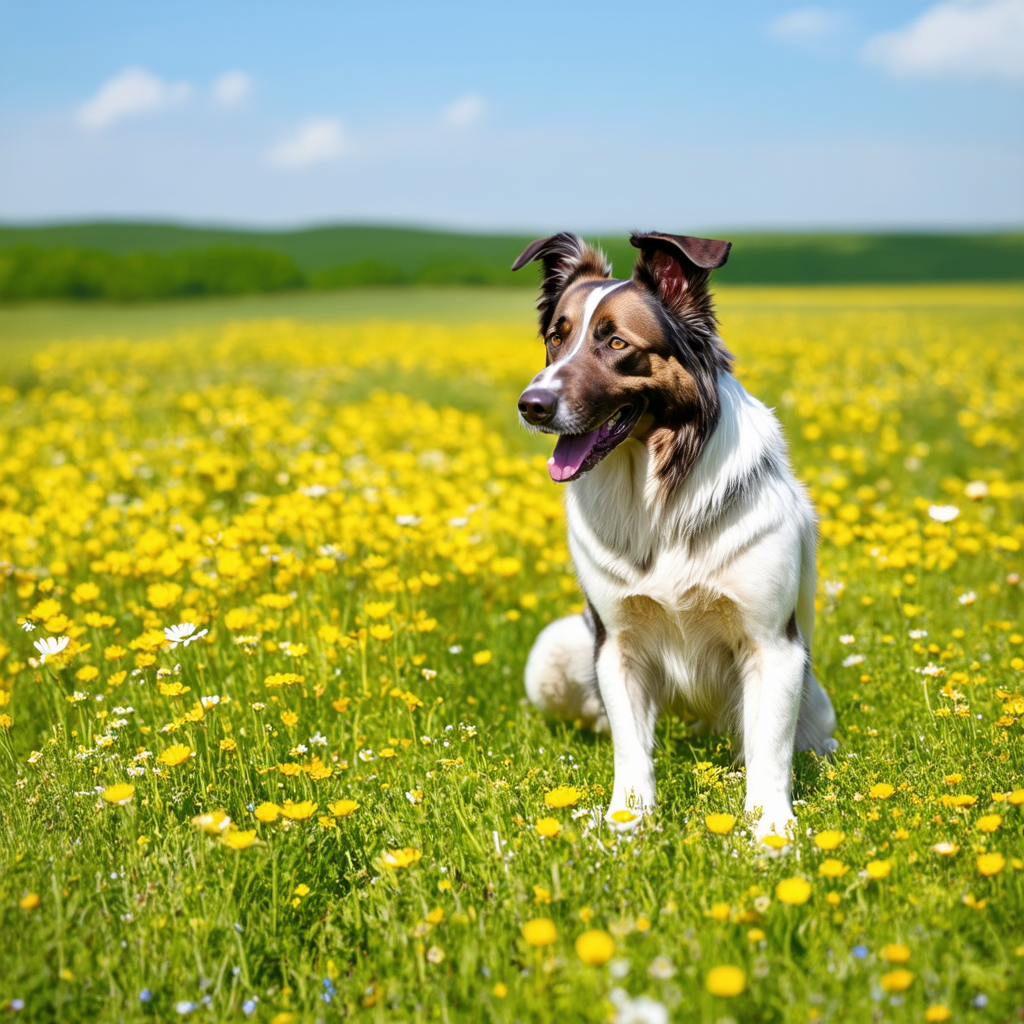

In [36]:
from diffusers import DiffusionPipeline
import torch

# Load the base model
pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    torch_dtype=torch.float16
)
pipeline.enable_sequential_cpu_offload()

# Create a prompt
prompt = "a majestic dog in a meadow of flowers"

# Generate an image
image = pipeline(prompt).images[0]
image.save(f"example_image.png")
display(image)

Pretty good right? Now let's see how we can customize SD3 to generate images of our own data.

## Customize SD3

To customize SD3 we need to create a clean dataset of images, and then finetune our model on that data.

## Download instance data images

To get you started we download an example dataset of dog images from the Hugging Face Hub.

In [28]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

alvan-nee-9M0tSjb-cpA-unsplash.jpeg:   0%|          | 0.00/677k [00:00<?, ?B/s]

alvan-nee-bQaAJCbNq3g-unsplash.jpeg:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

alvan-nee-eoqnr8ikwFE-unsplash.jpeg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

alvan-nee-Id1DBHv4fbg-unsplash.jpeg:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

alvan-nee-brFsZ7qszSY-unsplash.jpeg:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

'/mnt/c/Users/benni/Documents/nosana/demos/lora-notebook/dog'

In [32]:
!rm -rf dog/.cache

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute embeddings

SD3 needs to manually compute embeddings for the instance data. So this is what we do in the next step. We input a prompt with with unique code so the model learns how to generate images of our dog.

In [29]:
!python3 compute_embeddings.py \
    --prompt "photo of a skr dog" \
    --local_data_dir "dog" 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading pipeline components...: 100%|█████████████| 7/7 [00:01<00:00,  3.62it/s]
prompt_embeds.shape=torch.Size([1, 154, 4096]), negative_prompt_embeds.shape=torch.Size([1, 154, 4096]), pooled_prompt_embeds.shape=torch.Size([1, 2048]), torch.Size([1, 2048])
Max memory allocated: 10.552 GB
Data successfully serialized to embeddings.parquet


## Clear memory

Lets clear any excess cached memory so we have more space to finetune our model.

In [30]:
import torch
import gc


def flush():
    torch.cuda.empty_cache()
    gc.collect()

flush()

## Finetuning

In [33]:
!CUDA_VISIBLE_DEVICES=0 accelerate launch train_dreambooth_lora_sd3_miniature.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-3-medium-diffusers"  \
  --instance_data_dir="dog" \
  --data_df_path="embeddings.parquet" \
  --output_dir="trained-lora-weights" \
  --mixed_precision="fp16" \
  --instance_prompt="photo of a skr dog" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 --gradient_checkpointing \
  --use_8bit_adam \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --seed="0"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
/home/capito/.local/lib/python3.10/site-packages/accelerate/accelerator.py:443: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
11/06/2024 11:43:07 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'max_shift', 'base_image_seq_len', 'invert_sigmas', 'max_image_seq_len', 'use_dynamic_shifting', 'base_shift'} was not found in config. Values will be initialized to d

## Inference

Now it is time to test our customized SD3 model

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

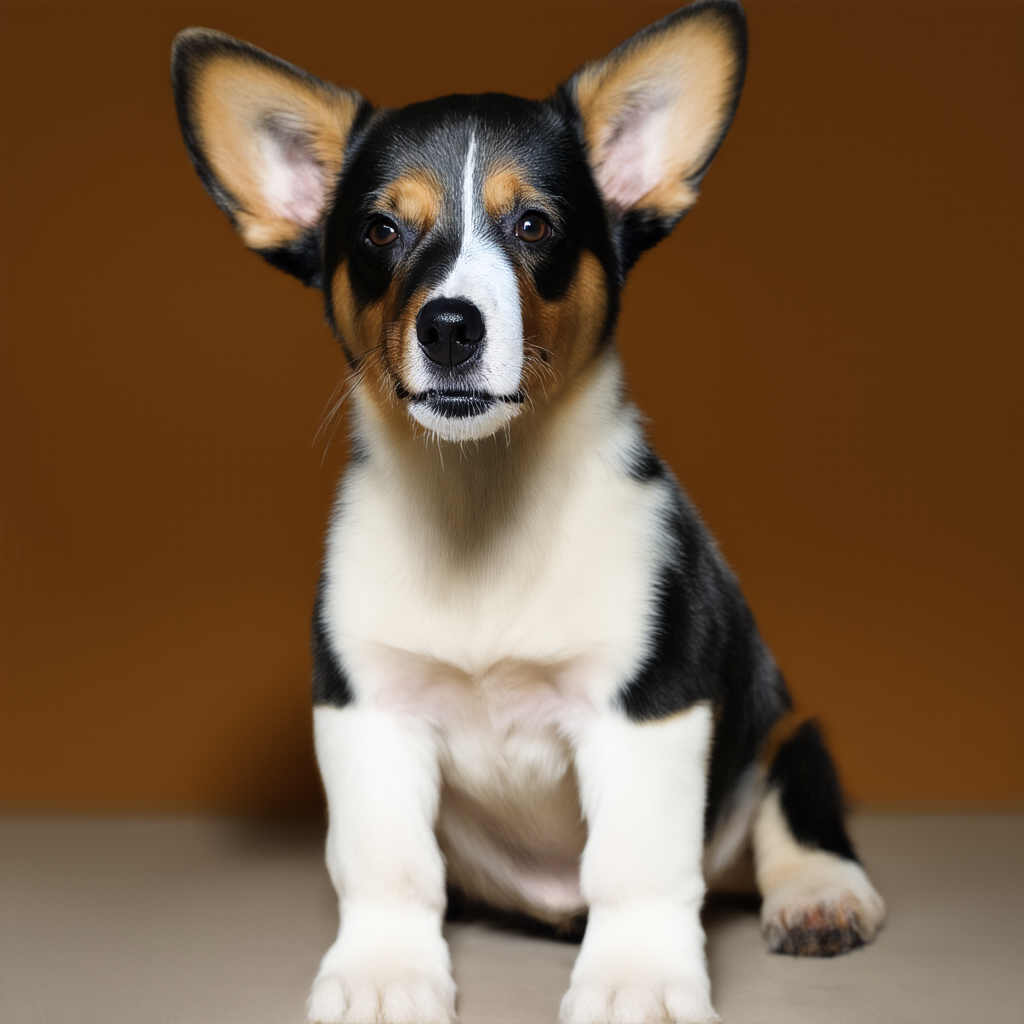

In [35]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    torch_dtype=torch.float16
)
lora_output_path = "trained-lora-weights"
pipeline.load_lora_weights(lora_output_path)

pipeline.enable_sequential_cpu_offload()

image = pipeline("photo of a skr dog").images[0]
image.save("dog.png")
display(image)